In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook
from scipy.optimize import minimize
from itertools import product
from xgboost import XGBRegressor

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import time
import random
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
ads = pd.read_csv('archive/ads.csv', parse_dates=['Time'])

In [3]:
ads

,Time,Ads
0,2017-09-13 00:00:00,80115
1,2017-09-13 01:00:00,79885
2,2017-09-13 02:00:00,89325
3,2017-09-13 03:00:00,101930
4,2017-09-13 04:00:00,121630
...,...,...
211,2017-09-21 19:00:00,155890
212,2017-09-21 20:00:00,123395
213,2017-09-21 21:00:00,103080
214,2017-09-21 22:00:00,95155


In [4]:
n = 24  # довжина сезону
Z = 5  # кількість клонів для кожного антитіла
hours = list(range(n))  # години

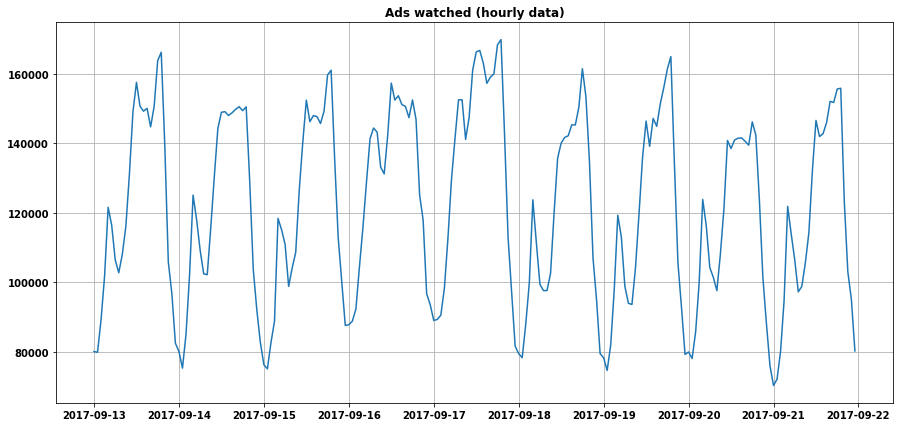

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Time, ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [6]:
ads = ads.set_index([pd.to_datetime(ads['Time'].values).day-12])
ads.index.names = ['Day']

# AISLFS 

In [7]:
def initialize_AB_and_AG(dataframe):
    """
    Функція для ініціалізації початкових значень антитіл та антигенів
    Аргументи:
        dataframe - pandas.DataFrame, початкові дані про кількість переглянутої реклами.
    Функція повертає значення:
        antigens - dict, антигени;
        antibodies - dict, антитіла;
        norm_dataframe - pandas.DataFrame, містить середні значення та середні квадратичні відхилення для кожного спостереження.
    """
    count = 0
    antigens = {}
    antibodies = {}
    number_of_days = dataframe.index.nunique()
    norm_dataframe = pd.merge(pd.merge(dataframe, dataframe.mean(level='Day'), on="Day"), dataframe.std(
        level='Day'), on="Day").rename(columns={'Ads_x': 'Ads', 'Ads_y': 'day_mean', 'Ads': 'day_std'})
    norm_dataframe['norm_ads'] = (
        norm_dataframe['Ads']-norm_dataframe['day_mean'])/norm_dataframe['day_std']
    for first_period in range(number_of_days):
        x = norm_dataframe.loc[(first_period+1,), ]
        x.reset_index(inplace=True, drop=True)
        x.rename(columns=lambda s: s+'_x', inplace=True)
        x_mean_std = norm_dataframe.loc[(
            first_period+1,), ['day_mean', 'day_std']]

        for second_period in range(number_of_days):

            if second_period > first_period and first_period + 1 >= second_period:

                count += 1
                y = pd.concat([norm_dataframe.loc[(second_period+1,), ['Time', 'Ads']
                                                  ].reset_index(drop=True), x_mean_std.reset_index(drop=True)], axis=1)
                y['norm_ads'] = (y['Ads']-y['day_mean'])/y['day_std']
                y.rename(columns=lambda s: s+'_y', inplace=True)
                antigens[str(count)] = pd.concat([x, y], axis=1)
                antibodies[str(count)] = {'p': x, 'q': y, 'paratope': pd.Series(
                    [True for i in range(n)]), 'r': None, 'P': None}

    return antigens, antibodies, norm_dataframe

In [8]:
def cross_reactivity_th(clone_antibody, antibody_num, antigens, antibodies, delta, c):
    """
    Функція для знаходження порогу перехресної реактивності
    Аргументи:
        clone_antibody - dict, клоноване антитіло;
        antibody_num - int, номер батьківського антитіла;
        antigens - dict, антигени;
        antibodies - dict, антитіла;
        delta - float, гіперпараметр для визначення класу антигенів;
        c - float, гіперпараметр для регулювання поріг перехресної реактивності.
    Функція повертає значення:
        clone_cross_reactivity_th - dict, пороги перехресної реактивності для клонів;
        dist_clone_AGs - np.array, відстані від клону до антигенів.
    """
    days = len(antigens.keys())
    list_values = []
    dist_clone_AGs = []

    for day in range(1, days+1):

        list_values.append(((antibodies[str(antibody_num)]['q'].loc[:, 'Ads_y'].values -
                             antigens[str(day)].loc[:, 'norm_ads_y'].values*antibodies[str(antibody_num)]['p'].loc[:, 'day_std_x'].values +
                             antibodies[str(antibody_num)]['p'].loc[:, 'day_mean_x'].values) /
                            antibodies[str(antibody_num)]['q'].loc[:, 'Ads_y'].values).mean())
        dist_clone_AGs.append(distance_clone_AG(clone_antibody, day, antigens))

    classes = np.where(np.array(list_values) < delta, 1, 2)
    dist_clone_AGs = np.array(dist_clone_AGs)

    if np.array(classes == 1).any():
        class_1_AG = max(dist_clone_AGs[classes == 1])
    else:
        class_1_AG = 1

    if np.array(classes == 2).any():
        class_2_AG = min(dist_clone_AGs[classes == 2])
    else:
        class_2_AG = 1

    clone_cross_reactivity_th = 1.5*(class_1_AG + c*(class_2_AG - class_1_AG))

    return clone_cross_reactivity_th, dist_clone_AGs

In [9]:
def distance_clone_AG(clone_antibody, day, antigens):
    """
    Функція для знаходження відстані від клону до антигенів
    Аргументи:
        clone_antibody - dict, клоноване антитіло;
        day - int, номер дня;
        antigens - dict, антигени;
    Функція повертає значення:
        final_dist - np.array, відстань від клону до антигенів;
    """
    dist = clone_antibody['p'].loc[:, 'norm_ads_x'].values - \
        antigens[str(day)].loc[:, 'norm_ads_x'].values
    filt_dist = dist*(clone_antibody['paratope'].values.astype(int))
    final_dist = np.sqrt(sum(filt_dist**2))
    return final_dist

In [10]:
def affinity_clone_AG(dist_clone_AGs, clone_cross_reactivity_th):
    """
    Функція для знаходження афінності між клоном там антигенами
    Аргументи:
        dist_clone_AGs - dict, відстані від клону до антигенів;
        clone_cross_reactivity_th - dict, пороги перехресної реактивності для клонів.
    Функція повертає значення афінностей.
    """
    return np.where(dist_clone_AGs > clone_cross_reactivity_th, 0, 1-dist_clone_AGs/clone_cross_reactivity_th)

In [11]:
def update_forecast(filtr, aff, antigens):
    """
    Функція для оновлення значень q для клонів антитіл
    Аргументи:
        filtr - np.array, фільтр значень які потрапили в облась гіперсфери з порогом перехресної реактивності;
        aff - np.array, афінності між клоном та антигенами;
        antigens - dict, антигени.
    Функція повертає значення:
        new_q - dict, нове значення q для клонів антитіл.
    """
    numerator = np.zeros(len(antigens['1']['Ads_y'].values))
    denominator = 0

    for key in antigens:
        if not filtr[int(key)-1]:
            break

        numerator += (antigens[key]['Ads_y'].values)*(aff[int(key)-1])
        denominator += aff[int(key)-1]

    new_q = numerator/denominator

    return new_q

In [12]:
def find_best_clone(clones, filtrs):
    """
    Функція для знаходження найкращого клону
    Аргументи:
        clones - dict, клоноване антитіло;
        filtrs - np.array, фільтри значень які потрапили в облась гіперсфери з порогом перехресної реактивності;
    Функція повертає значення:
        best_clone - dict, найкращий клон;
    """
    new_filter = []
    for filtr in filtrs:
        new_filter.append(sum(filtr))

    new_filter = np.array(new_filter)
    arg_max = np.argwhere(new_filter == np.amax(new_filter)).flatten().tolist()
    num_paratope = []

    for arg in arg_max:
        num_paratope.append(sum(clones[arg]['paratope']))

    best_clone_id = arg_max[np.array(num_paratope).argmin()]
    best_clone = clones[best_clone_id]

    return best_clone

In [13]:
def train(train_data, sigma, delta, c):
    """
    Функція для тренування імунної моделі
    Аргументи:
        train_data - pandas.DataFrame, дані для тренування про кількість переглянутої реклами;
        sigma - float, середні квадратичні відхилення в нормальному розподілі для кількості мутацій в клонах;
        delta - float, гіперпараметр для визначення класу антигенів;
        c - float, гіперпараметр для регулювання поріг перехресної реактивності.
    Функція повертає значення:
        memory_AB - dict, зберігаємо найкращі антитіла в клітини пам'яті;
    """
    antigens, antibodies, norm_dataframe = initialize_AB_and_AG(train_data)
    memory_AB = {}
    st_crit = 10

    for antibody_id in range(1, len(antibodies)+1):
        parent_AB = copy.deepcopy(antibodies[str(antibody_id)])

        for _ in range(st_crit):
            clones = {}

            aff_clones_AGs_list = {}
            filtrs = np.array([])

            for clone_id in range(Z):

                clone_antibody = copy.deepcopy(parent_AB)
                numb_filter_changes = int(np.abs(np.random.normal(0, sigma)))
                numb_filter_changes = 1 if numb_filter_changes == 0 else n if numb_filter_changes > n else numb_filter_changes
                inverse_indices = random.sample(hours, numb_filter_changes)

                # mutation
                clone_antibody['paratope'][inverse_indices] = ~clone_antibody['paratope'][inverse_indices]
                clones[clone_id] = copy.deepcopy(clone_antibody)
                clone_cross_reactivity_th, dist_clone_AGs = cross_reactivity_th(
                    clone_antibody, antibody_id, antigens, antibodies, delta, c)
                clones[clone_id]['r'] = clone_cross_reactivity_th

                aff_clones_AGs_list['clone_'+str(clone_id)] = affinity_clone_AG(
                    dist_clone_AGs, clone_cross_reactivity_th)

                filtr = dist_clone_AGs < clone_cross_reactivity_th
                clones[clone_id]['P'] = sum(filtr)
                filtrs = np.append(filtrs, filtr)

                new_q = update_forecast(
                    filtr, aff_clones_AGs_list['clone_'+str(clone_id)], antigens)
                # тут повинно бути нормовані
                clones[clone_id]['q']['Ads_y'] = new_q

            filtrs = filtrs.reshape((Z, -1))
            parent_AB = find_best_clone(clones, filtrs)

        memory_AB[antibody_id] = copy.deepcopy(parent_AB)
    return memory_AB

In [14]:
def predict(memory_AB):
    """
    Функція для прогнозування нових значень часового ряду
    Аргументи:
        memory_AB - dict, збережені найкращі антитіла в клітинах пам'яті;
    Функція повертає значення:
        pred - np.array, прогнозовані значення.
    """
    aff = np.array([])
    Ps = np.array([])

    for ab in memory_AB:
        dist = memory_AB[ab]['p'].loc[:, 'norm_ads_x'].values
        filt_dist = dist*(memory_AB[ab]['paratope'].values.astype(int))
        dist = np.sqrt(sum(filt_dist**2))
        aff = np.append(aff, affinity_clone_AG(dist, memory_AB[ab]['r']))
        Ps = np.append(Ps, memory_AB[ab]['P'])

    denom = np.dot(aff, Ps)
    pred = np.zeros(len(memory_AB[1]['q']))

    for ab in range(1, len(memory_AB)+1):
        pred += (Ps[ab-1]*aff[ab-1]/denom) * \
            memory_AB[ab]['q'].loc[:, 'Ads_y'].values

    return pred

In [15]:
def find_parameters(train_data, test_data, sigmas, deltas, cs):
    """
    Функція для знаходження найкращих гіперпараметрів
    Аргументи:
        train_data - pandas.DataFrame, дані для тренування;
        test_data - pandas.DataFrame, дані для тестування;
        sigmas - list, список гіперпараметрів sigma;
        deltas - list, список гіперпараметрів delta;
        cs - list, список гіперпараметрів с.
    Функція повертає значення:
        best_params - tuple, найкращі гіперпараметри.
    """
    norm_test = pd.merge(pd.merge(test_data, test_data.mean(level='Day'), on="Day"), test_data.std(
        level='Day'), on="Day").rename(columns={'Ads_x': 'Ads', 'Ads_y': 'day_mean', 'Ads': 'day_std'})
    norm_test['norm_ads'] = (
        norm_test['Ads']-norm_test['day_mean'])/norm_test['day_std']
    best_score = np.inf
    test_values = test_data['Ads'].values

    for params in list(product(sigmas, deltas, cs)):

        memory_AB = train(train_data, *params)
        pred_values = predict(memory_AB)

        if np.isnan(pred_values).any():
            continue

        metric = mean_squared_error(test_values, pred_values)
        if metric < best_score:
            best_score = metric
            best_params = params

    return best_params

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Функція для знаходження середньої абсолютної відсоткової помилки
    Аргументи:
        y_true - np.array, справжні значення часового ряду;
        y_pred - np.array, спрогнозовані значення часового ряду.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
% % time
sigmas = np.linspace(3, 5, 5)
deltas = np.linspace(2.08, 2.17, 10)
cs = np.linspace(0.2, 1, 7)
best_params = find_parameters(ads.loc[1:7], ads.loc[8], sigmas, deltas, cs)

Wall time: 10min 47s


In [18]:
best_params

(4.0, 2.1, 0.2)

In [19]:
while True:
    memory_AB = train(ads.loc[1:8], *best_params)
    pred_values = predict(memory_AB)
    if not any(np.isnan(pred_values)):
        break

In [21]:
IA_metrics = np.array([r2_score(ads.loc[9]['Ads'].values, pred_values), median_absolute_error(ads.loc[9]['Ads'].values, pred_values),
                       mean_absolute_error(ads.loc[9]['Ads'].values, pred_values), mean_squared_error(
                           ads.loc[9]['Ads'].values, pred_values),
                       mean_squared_log_error(ads.loc[9]['Ads'].values, pred_values), mean_absolute_percentage_error(ads.loc[9]['Ads'].values, pred_values)])
print('r2 ', r2_score(ads.loc[9]['Ads'].values, pred_values))
print('median absolute error ', median_absolute_error(
    ads.loc[9]['Ads'].values, pred_values))
print('mean absolute error ', mean_absolute_error(
    ads.loc[9]['Ads'].values, pred_values))
print('mean squared error ', mean_squared_error(
    ads.loc[9]['Ads'].values, pred_values))
print('mean squared log error ', mean_squared_log_error(
    ads.loc[9]['Ads'].values, pred_values))
print('mean absolute percentage error ', mean_absolute_percentage_error(
    ads.loc[9]['Ads'].values, pred_values))

r2  0.9504668433253289
median absolute error  4615.0052397408435
mean absolute error  5137.214928648997
mean squared error  36704181.371086426
mean squared log error  0.003500070195501344
mean absolute percentage error  4.967078003628092


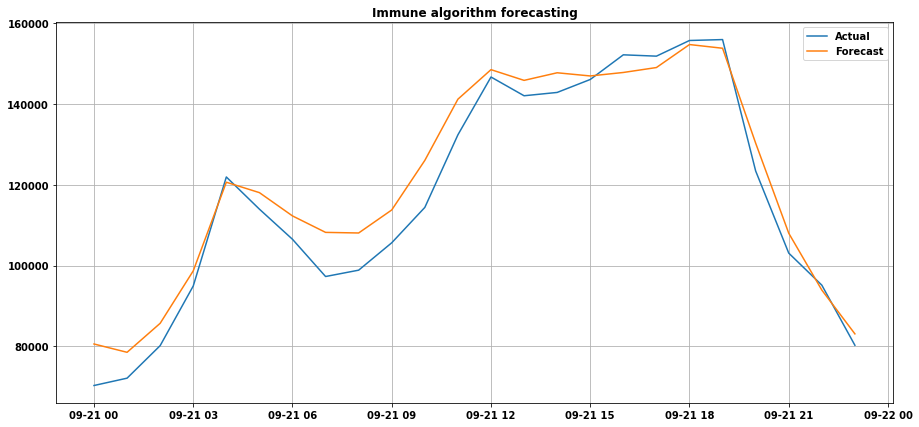

In [22]:
ads_pred = copy.deepcopy(ads.loc[9])
ads_pred['Ads'] = pred_values

plt.figure(figsize=(15, 7))
plt.plot(ads.loc[9].set_index('Time'), label="Actual")
plt.plot(ads_pred.set_index('Time'), label="Forecast")
# error = mean_absolute_percentage_error(ads.loc[8]['Ads'].values,ads_pred['Ads'].values)
plt.title("Immune algorithm forecasting")
plt.grid(True)
plt.legend(loc="best")
plt.show()

# Інші моделі

## Модель Хольта-Вінтерса

In [23]:
ads_ = pd.read_csv('archive/ads.csv', index_col=['Time'], parse_dates=['Time'])
train_data = ads_.Ads[:-24]
test_data = ads_.Ads[-24:]

In [24]:
class HoltWinters:

    """
    Модель Хольта-Вінтерса
        series - початковий часовий ряд
        slen - довжина сезону
        alpha, beta, gamma - параметри моделі Хольта-Вінтерса
        n_preds - горизонт прогнозування
        scaling_factor - ширина довірчого інтервала
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):

        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):

        sum = 0.0

        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):

        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)

        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))

        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen *
                                                    j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):

        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0:

                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series):

                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) +
                                   seasonals[i % self.slen])
                self.PredictedDeviation.append(
                    self.PredictedDeviation[-1]*1.01)

            else:

                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * \
                    (val-seasonals[i % self.slen]) + \
                    (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i % self.slen] = self.gamma * \
                    (val-smooth) + (1-self.gamma)*seasonals[i % self.slen]
                self.result.append(smooth+trend+seasonals[i % self.slen])

                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [25]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
    Функція для знаходження помилки CV
    Аргументи:
        params - параметри для оптимізації
        series - часовий ряд
        slen - довжина сезону
    """
    errors = []
    values = series.values
    alpha, beta, gamma = params
    tscv = TimeSeriesSplit(n_splits=3)

    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen,
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [26]:
% % time
x = [0, 0, 0]
opt = minimize(timeseriesCVscore, x0=x,
               args=(train_data, mean_squared_log_error),
               method="TNC", bounds=((0, 1), (0, 1), (0, 1)))
alpha_final, beta_final, gamma_final = opt.x

model = HoltWinters(train_data, slen=24,
                    alpha=alpha_final,
                    beta=beta_final,
                    gamma=gamma_final,
                    n_preds=48, scaling_factor=3)
model.triple_exponential_smoothing()

Wall time: 4.61 s


In [27]:
HW_metrics = np.array([r2_score(test_data.values, model.result[-48:-24]), median_absolute_error(test_data.values, model.result[-48:-24]),
                       mean_absolute_error(test_data.values, model.result[-48:-24]), mean_squared_error(
                           test_data.values, model.result[-48:-24]),
                       mean_squared_log_error(test_data.values, model.result[-48:-24]), mean_absolute_percentage_error(test_data.values, model.result[-48:-24])])
print('r2 ', r2_score(test_data.values, model.result[-48:-24]))
print('median absolute error ', median_absolute_error(
    test_data.values, model.result[-48:-24]))
print('mean absolute error ', mean_absolute_error(
    test_data.values, model.result[-48:-24]))
print('mean squared error ', mean_squared_error(
    test_data.values, model.result[-48:-24]))
print('mean squared log error ', mean_squared_log_error(
    test_data.values, model.result[-48:-24]))
print('mean absolute percentage error ', mean_absolute_percentage_error(
    test_data.values, model.result[-48:-24]))

r2  0.9245051342675664
median absolute error  4917.178001427965
mean absolute error  6115.4167103728105
mean squared error  55941866.629428916
mean squared log error  0.0042303522524701756
mean absolute percentage error  5.118861874835986


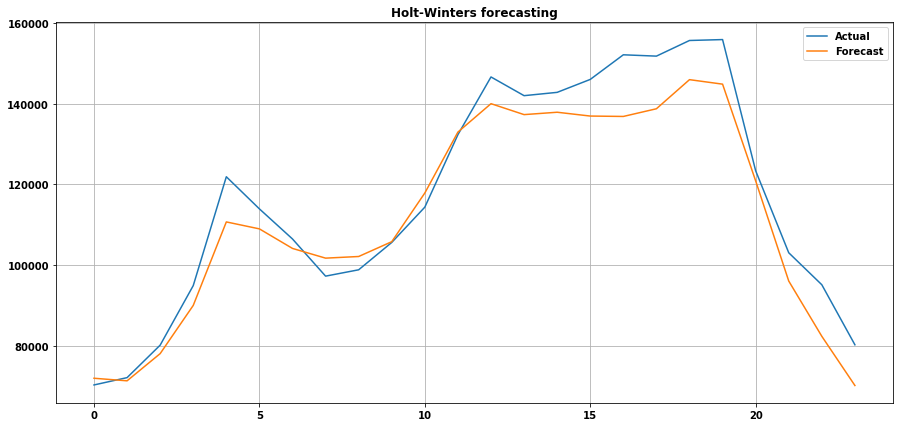

In [28]:
plt.figure(figsize=(15, 7))
plt.plot(test_data.values, label='Actual')
plt.plot(model.result[-48:-24], label='Forecast')
plt.title("Holt-Winters forecasting")
plt.grid(True)
plt.legend()
plt.show()

## SARIMA

In [29]:
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 24
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [30]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
    Функція для знаходження оптимальних параметрів
    Аргументи:
        parameters_list - list with (p, q, P, Q) tuples
        D - сезонна інтеграція
        s - довжина сезону
    """
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):

        try:
            model = sm.tsa.statespace.SARIMAX(train_data, order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(
        by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [31]:
% % time
result_table = optimizeSARIMA(parameters_list, d, D, s)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anacon

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anacon

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  192
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 24)   Log Likelihood               -1695.666
Date:                              Fri, 18 Jun 2021   AIC                           3407.332
Time:                                      13:38:10   BIC                           3432.276
Sample:                                  09-13-2017   HQIC                          3417.457
                                       - 09-20-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6163      0.320      1.925      0.054      -0.011       1.244
ar.L2         -0.33

In [32]:
def plotSARIMA(series, model, n_steps):
    """
    Функція побудови моделі
    Аргументи:
        series - часовий ряд
        model - натренована SARIMA модель
        n_steps - горизонт прогнозу
    """
    data = copy.deepcopy(series)
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues

    forecast = model.predict(start=data.shape[0], end=data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)

    return forecast.values

In [33]:
forecast = plotSARIMA(ads_.iloc[:-24], best_model, 24)

In [34]:
SARIMA_metrics = np.array([r2_score(test_data.values, forecast[-24:]), median_absolute_error(test_data.values, forecast[-24:]),
                           mean_absolute_error(
                               test_data.values, forecast[-24:]), mean_squared_error(test_data.values, forecast[-24:]),
                           mean_squared_log_error(test_data.values, forecast[-24:]), mean_absolute_percentage_error(test_data.values, forecast[-24:])])
print('r2 ', r2_score(test_data.values, forecast[-24:]))
print('median absolute error ', median_absolute_error(
    test_data.values, forecast[-24:]))
print('mean absolute error ', mean_absolute_error(
    test_data.values, forecast[-24:]))
print('mean squared error ', mean_squared_error(
    test_data.values, forecast[-24:]))
print('mean squared log error ', mean_squared_log_error(
    test_data.values, forecast[-24:]))
print('mean absolute percentage error ',
      mean_absolute_percentage_error(test_data.values, forecast[-24:]))

r2  0.7345279741077078
median absolute error  9672.753349065504
mean absolute error  11731.755434657802
mean squared error  196715372.9227805
mean squared log error  0.01576241105633251
mean absolute percentage error  10.336955623167448


In [35]:
len(forecast)

217

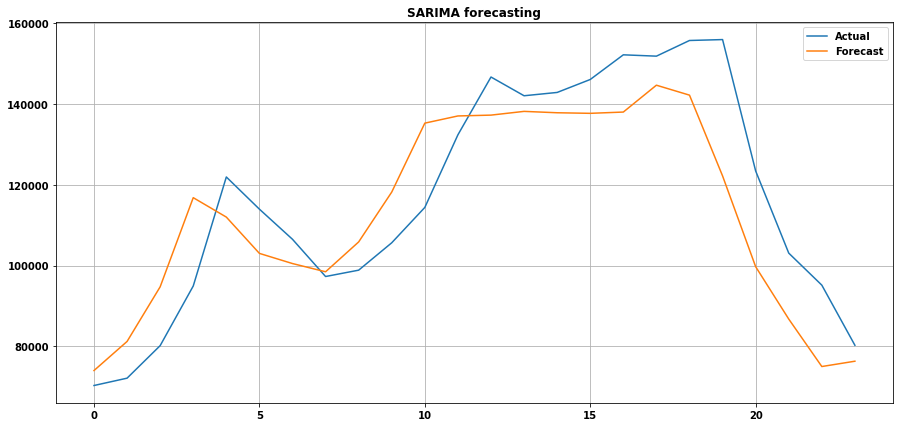

In [36]:
plt.figure(figsize=(15, 7))
plt.plot(test_data.values, label='Actual')
plt.plot(forecast[-24:], label='Forecast')
plt.title("SARIMA forecasting")
plt.grid(True)
plt.legend()
plt.show()

## Лінійна регресія

In [37]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [38]:
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [39]:
tscv = TimeSeriesSplit(n_splits=5)
y_train = data.iloc[:-24].dropna().y
X_train = data.iloc[:-24].dropna().drop(['y'], axis=1)
X_test = data.iloc[-24:].drop(['y'], axis=1)
y_test = data.iloc[-24:].y

In [40]:
X_train

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Day,,,,,,,,,,,,,,,,,,,
2,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0
2,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0
2,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0
2,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0
2,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,140990.0,138555.0,140850.0,121250.0,108265.0,97635.0,101440.0,104290.0,116335.0,123880.0,100010.0,85785.0,78110.0,79980.0,79270.0,92855.0,105585.0,134090.0,165010.0
8,141525.0,140990.0,138555.0,140850.0,121250.0,108265.0,97635.0,101440.0,104290.0,116335.0,123880.0,100010.0,85785.0,78110.0,79980.0,79270.0,92855.0,105585.0,134090.0
8,141590.0,141525.0,140990.0,138555.0,140850.0,121250.0,108265.0,97635.0,101440.0,104290.0,116335.0,123880.0,100010.0,85785.0,78110.0,79980.0,79270.0,92855.0,105585.0


In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
metrics = []


def plotModelResults(model, title, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="Forecast", linewidth=2.0)
    plt.plot(y_test.values, label="Actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    metrics.append(np.array([r2_score(prediction, y_test), median_absolute_error(prediction, y_test),
                             mean_absolute_error(prediction, y_test), mean_squared_error(
                                 prediction, y_test),
                             mean_squared_log_error(prediction, y_test), mean_absolute_percentage_error(prediction, y_test)]))
    print('r2 ', r2_score(prediction, y_test))
    print('median absolute error ', median_absolute_error(prediction, y_test))
    print('mean absolute error ', mean_absolute_error(prediction, y_test))
    print('mean squared error ', mean_squared_error(prediction, y_test))
    print('mean squared log error ', mean_squared_log_error(prediction, y_test))
    print('mean absolute percentage error ',
          mean_absolute_percentage_error(prediction, y_test))

    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plt.close()

    return metrics


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

r2  0.8539725113764713
median absolute error  5090.531571802159
mean absolute error  6269.99441015131
mean squared error  65239537.02739087
mean squared log error  0.006170645823991034
mean absolute percentage error  5.585997175950699


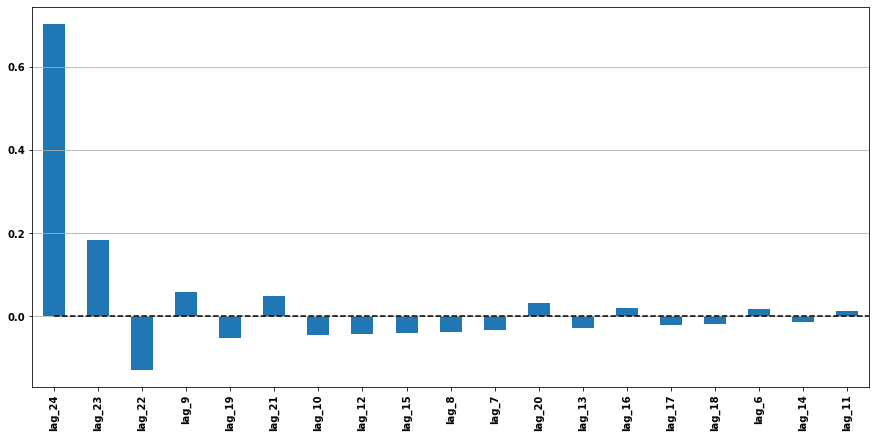

In [43]:
plotModelResults(lr, "Linear regression forecasting")
plotCoefficients(lr)
LR_metrics = metrics[0]

In [44]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
plotModelResults(xgb, "XGBoost regression forecasting", X_train=X_train,
                 X_test=X_test, plot_intervals=False, plot_anomalies=False)
XGB_metrics = metrics[-1]

r2  0.8829192879718979
median absolute error  6396.390625
mean absolute error  7171.362630208333
mean squared error  69730609.21973674
mean squared log error  0.006026691860132699
mean absolute percentage error  6.390100940832609


In [46]:
pd.DataFrame([IA_metrics, HW_metrics, SARIMA_metrics, LR_metrics, XGB_metrics], columns=['r2', 'median absolute error', 'mean absolute error',
                                                                                         'mean squared error', 'mean squared log error', 'mean absolute percentage error'], index=['Immune algorithm', 'Holt-Winters', 'SARIMA', 'LR', 'XGBoost'])

,r2,median absolute error,mean absolute error,mean squared error,mean squared log error,mean absolute percentage error
Immune algorithm,0.950467,4615.005240,5137.214929,3.670418e+07,0.003500,4.967078
Holt-Winters,0.924505,4917.178001,6115.416710,5.594187e+07,0.004230,5.118862
SARIMA,0.734528,9672.753349,11731.755435,1.967154e+08,0.015762,10.336956
LR,0.853973,5090.531572,6269.994410,6.523954e+07,0.006171,5.585997
XGBoost,0.882919,6396.390625,7171.362630,6.973061e+07,0.006027,6.390101
